In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time
import numpy as np
import pickle
from collections import deque

%matplotlib inline
IMG_HEIGHT = 128
IMG_WIDTH = 64

ORIENTATIONS = 12
PPC = 16
CPB = 4
COLORSPACE = 'LUV'

HEAT_MAP_HISTORY = deque(maxlen=10)
HEAT_MAP_HISTORY.clear()

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm = 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def extract_features(imgs, cspace=COLORSPACE, orientations=ORIENTATIONS, 
                        pix_per_cell=PPC, cell_per_block=CPB, hog_channel=0, spatial_size=(32,32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
#         image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orientations, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orientations, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features=bin_spatial(feature_image, spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features=color_hist(feature_image, hist_bins)
        
#         print('Hog Features shape: ',hog_features.shape)
        
        all_features = np.hstack(( spatial_features, hist_features, hog_features))
        # Append the new feature vector to the features list
        features.append(all_features)
    # Return list of feature vectors
    return features

In [6]:
# def augment():
#     for img_class, directory in enumerate(['carla_red', 'carla_yellow', 'carla_green', 'carla_none']):
#         for i, file_name in enumerate(glob.glob("data/{}/*.jpg".format(directory))):
#             file = cv2.imread(file_name)
#             image = plt.imread(file_name)
#             flipped_image = cv2.flip(image,1)
#             new_file_name = file_name.split('.')[:-1]
#             new_file_name = ''.join(new_file_name) + '_flipped.jpg'
#             plt.imsave(new_file_name,flipped_image)
# augment()

In [100]:
from sklearn.svm import SVC
from time import time

def train_SVC():
    tl_red = []
    tl_green = []
    tl_yellow = []
    tl_none = []
    for img_class, directory in enumerate(['sim_red', 'sim_yellow', 'sim_green', 'sim_none']):
        for i, file_name in enumerate(glob.glob("data/{}/*.*".format(directory))):
            file = cv2.imread(file_name)

            file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB);
            resized = cv2.resize(file, (IMG_WIDTH,IMG_HEIGHT))
            resized = resized/255.
            resized = resized.astype(np.float32)

            if(img_class == 0):
                tl_red.append(resized)
            elif(img_class == 1):
                tl_yellow.append(resized)
            elif(img_class == 2):
                tl_green.append(resized)
            elif(img_class == 3):
                tl_none.append(resized)

    #         if (i < 3):
    #            plt.imshow(file)
    #            plt.show()

    
    colorspace = COLORSPACE # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = ORIENTATIONS
    pix_per_cell = PPC
    cell_per_block = CPB
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"

    t = time()
    tl_red_features = extract_features(tl_red, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    tl_yellow_features = extract_features(tl_yellow, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    tl_green_features = extract_features(tl_green, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    tl_none_features = extract_features(tl_none, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    print('Traffic Light red shape',tl_red_features[0].shape)
    t2 = time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((tl_none_features, tl_red_features, tl_yellow_features, tl_green_features )).astype(np.float64)

    # Define the labels vector
    none_label = np.array([0]*len(tl_none))
    red_label = np.array([1]*len(tl_red))
    yellow_label = np.array([2]*len(tl_yellow))
    green_label = np.array([3]*len(tl_green))
    y = np.hstack((none_label, red_label, yellow_label, green_label))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a non-linear SVC 
    svc = SVC(kernel='rbf',C=100.0)    
    
    # Check the training time for the SVC
    t=time()
    svc.fit(X_train, y_train)
    t2 = time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t = time()
    print('My SVC predicts:     ', svc.predict(X_test))
    print('For these',len(y_test), 'labels: ', y_test)
    t2 = time()
    print(round(t2-t, 5), 'Seconds to predict', len(y_test),'labels with SVC')
    
    # Save the model
    with open('sim_tl_classifier_model_svc.pickle','wb') as pickle_file:
        print('Saving SVC in pickle.....')
        pickle.dump({'svc': svc, 'scaler': X_scaler}, pickle_file)
        print('SVC saved.')

In [101]:
train_SVC()

Traffic Light red shape (4128,)
4.59 Seconds to extract HOG features...
Using: 12 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 4128
5.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9879
My SVC predicts:      [1 3 1 2 3 2 0 0 2 0 0 3 3 3 1 1 3 1 1 3 2 0 2 0 2 3 1 1 1 1 1 2 0 0 0 2 2
 1 0 3 0 3 1 3 0 2 3 3 1 0 2 2 2 1 0 0 1 3 3 2 2 1 3 0 0 0 3 0 0 3 1 3 3 1
 3 2 3 0 2 0 2 2 3 0 3 3 2 3 3 2 0 1 3 0 2 2 3 1 3 3 2 1 2 1 3 1 2 2 0 0 1
 1 0 2 2 0 2 0 2 1 1 0 1 2 0 3 3 3 0 2 1 1 0 1 2 0 0 3 1 3 0 3 3 2 3 3 3 0
 1 1 3 1 2 3 3 2 2 2 0 1 3 2 1 0 0 1 1 1 0 2 1 1 3 1 3 2 2 1 2 1 3 3 2 2 1
 1 3 1 3 0 2 1 0 1 0 1 0 1 3 3 3 1 1 0 2 1 0 2 1 0 1 1 0 2 3 1 3 0 2 2 0 3
 0 3 0 3 3 0 1 1 2 2 3 1 1 3 3 3 2 0 3 2 1 3 1 3 1 2]
For these 248 labels:  [1 3 1 2 3 2 0 0 2 0 0 3 3 3 1 1 3 1 1 3 2 0 2 0 2 3 1 1 1 1 1 2 0 0 0 2 2
 1 0 3 0 3 1 3 0 2 3 3 1 0 2 2 2 1 0 0 1 3 3 2 2 1 3 0 0 0 3 3 0 3 1 3 3 1
 3 2 3 0 2 0 2 2 3 0 3 3 2 3 3 2 0 1 3 0 2 2 3 1 3 3 2 1 2 1 3 1 2 2 0 0 1
 1

In [98]:
def get_saved_SVC():
    print('Loading model....')
    with open('carla_tl_classifier_model_svc.pickle','rb') as pickle_file:
        print('SVC loaded')
        obj = pickle.load(pickle_file)
        return obj[ 'svc' ], obj[ 'scaler' ]

In [99]:
SVC, SCALER = get_saved_SVC()

Loading model....
SVC loaded


In [75]:
def manual_test():
    image = plt.imread('./test_images/carla_green.jpg')
    image = cv2.resize(image,(IMG_WIDTH,IMG_HEIGHT))
    print(image.shape)
    
    image = image/255.
    image = image.astype(np.float32)
    
    features = extract_features([image])
    # Scale features and make a prediction
    test_features = SCALER.transform(np.hstack(features[0]).reshape(1, -1))   

    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
    test_prediction = SVC.predict(test_features)
    print(test_prediction)
manual_test()

(128, 64, 3)
[3]


In [76]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [77]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [78]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

In [79]:
def hot2rgb( heatmap ):
    min_value, max_value = np.amin(heatmap), np.amax(heatmap)
    normalized_hm = ( heatmap - min_value ) / ( max_value - min_value )
    cmap = plt.get_cmap('hot')
    rgba = cmap(normalized_hm) * 255
    
    r,g,b = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2]
    return np.dstack((r,g,b))

In [87]:
def find_traffic_light(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255.0
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = np.copy(img_tosearch)
    if type(ctrans_tosearch) == None:
        return draw_img, box_list
    
#     ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if COLORSPACE != 'RGB':
        if COLORSPACE == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif COLORSPACE == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif COLORSPACE == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif COLORSPACE == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif COLORSPACE == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
#     print('nyblocks: ', nyblocks)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
#     for simulator
#     cells_per_step = 1  # Instead of overlap, define how many cells to step

#     for carla
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
#     print('GEtting hog features with Orientations, PPC, CPB', orient, pix_per_cell, cell_per_block)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    red = np.random.randint(1,200)
    green = np.random.randint(100,250)
    for xb in range(nxsteps):
        ypos = 0 #since scaling factor along y will always be 1
        xpos = xb*cells_per_step
        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos+nyblocks, xpos:xpos+nblocks_per_window].ravel()
#         hog_feat2 = hog2[ypos:ypos+nyblocks, xpos:xpos+nblocks_per_window].ravel()
#         hog_feat3 = hog3[ypos:ypos+nyblocks, xpos:xpos+nblocks_per_window].ravel()

        hog_features = np.hstack((hog_feat1))
#         print('Hog Features shape: ',hog_features.shape, 'Blocks per window: ', nblocks_per_window)

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        # Extract the image patch
        subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+int(window/2)], (IMG_WIDTH,IMG_HEIGHT))
#         print( 'Sub-Image shape',subimg.shape )
        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

#         print('Test Features shape:', (np.hstack(( spatial_features, hist_features, hog_features)).reshape(1, -1)).shape)
        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack(( spatial_features, hist_features, hog_features)).reshape(1, -1))   

        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)

        if test_prediction[0] == 1:
            print("Red light")
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
#             cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+2*win_draw+ystart),(0,0,255),7) 
            box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+2*win_draw+ystart)])
#             plt.figure()
#             subimg = cv2.cvtColor(subimg, cv2.COLOR_YCrCb2RGB)
#             plt.imshow(subimg)
    
#         if test_prediction == 2:
#             print("Yellow light")
        
#         if test_prediction == 3:
#             print("Green light")
            
        cv2.rectangle(draw_img,(np.int(xleft*scale), np.int(ytop*scale)+ystart),(np.int(xleft*scale)+np.int(window*scale),np.int(ytop*scale)+np.int(2*window*scale)+ystart),(red,green,0),3)
    
    return draw_img, box_list

In [94]:
from scipy.ndimage.measurements import label

def pipeline(img):
    
    global HEAT_MAP_HISTORY
    
    svc = SVC
    X_scaler = SCALER
    orient = ORIENTATIONS
    pix_per_cell = PPC
    cell_per_block = CPB
    spatial_size = (32,32)
    hist_bins = 32
    
#     for simulator
#     ystart_list = [215,250,285]
#     ystop_list = [407,410,445]
#     scale_list = [192/IMG_HEIGHT,160/IMG_HEIGHT, 160/IMG_HEIGHT]

#     for carla
    ystart_list = [230,220]
    ystop_list = [300,310]
    scale_list = [70/IMG_HEIGHT,90/IMG_HEIGHT]

    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_map_with_history = np.zeros_like(img[:,:,0]).astype(np.float)
    for ystart, ystop, scale in zip(ystart_list,ystop_list,scale_list):
        out_img, box_list = find_traffic_light(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat_map = add_heat(heat_map,box_list)
        plt.figure(figsize=(15,10))
        plt.subplot(1,2,1)
        plt.imshow(out_img)
        plt.subplot(1,2,2)
        plt.imshow(heat_map, cmap='hot')

    # Heat map history
    #for simulator
#     HEAT_MAP_HISTORY.append(apply_threshold(heat_map,0))

#     for carla
    HEAT_MAP_HISTORY.append(apply_threshold(heat_map,2))
    
    for h_map in HEAT_MAP_HISTORY:
        heat_map_with_history += np.array(h_map)
        
        
    
    # Clip heat_map_with_history    
    heat_map_with_history = np.clip(heat_map_with_history, 0, 255)
    
    #Apply Threshold
    #for simulator
#     heat_map_with_history = apply_threshold(heat_map_with_history, min(len(HEAT_MAP_HISTORY), 1))
    #for carla
    heat_map_with_history = apply_threshold(heat_map_with_history, min(len(HEAT_MAP_HISTORY), 3))
    
    # Find final boxes from heatmap using label function
    labels = label(heat_map_with_history)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heat_map_with_history


In [95]:
def process_clip(image):
    result, heatmap = pipeline( image )
#     plt.figure(figsize=(15,10))
    
#     plt.subplot(1,2,1)
#     plt.imshow( heatmap, cmap='hot' )
    
#     plt.subplot(1,2,2)
#     plt.imshow( result )
    
    heatmap = cv2.resize(heatmap,None,fx=0.25,fy=0.25,interpolation = cv2.INTER_AREA)
    rgb_img = hot2rgb(heatmap)
    result[:int(result.shape[0]*0.25),int(result.shape[1]*0.75):result.shape[1] ] = result[:int(result.shape[0]*0.25),int(result.shape[1]*0.75):result.shape[1] ]*0.3 + 0.7*rgb_img
    return result

./test_images\carla_test.jpg
Red light
Red light


C:\Users\Arindam Baidya\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arindam Baidya\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


./test_images\carla_test2.jpg
Red light
Red light
Red light
Red light
./test_images\carla_test3.jpg
Red light


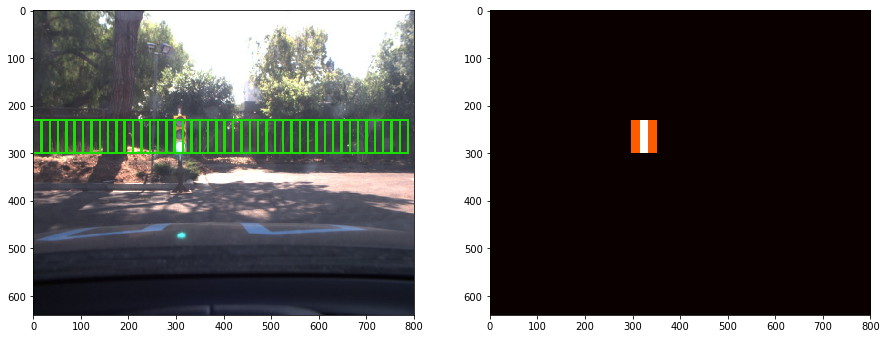

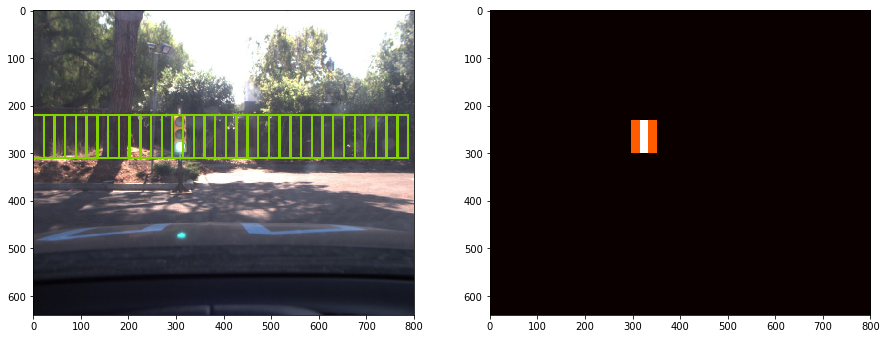

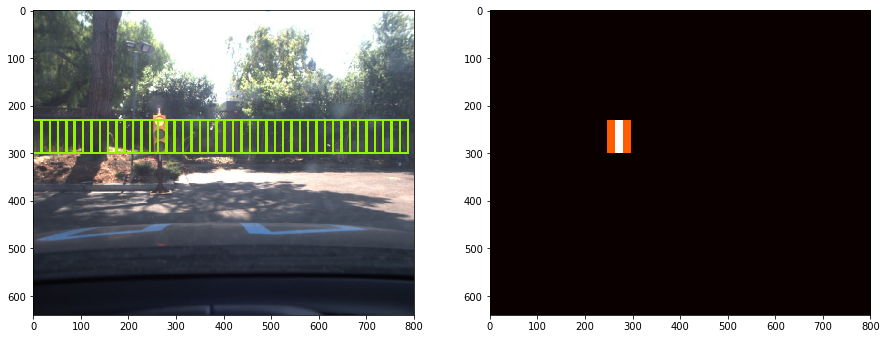

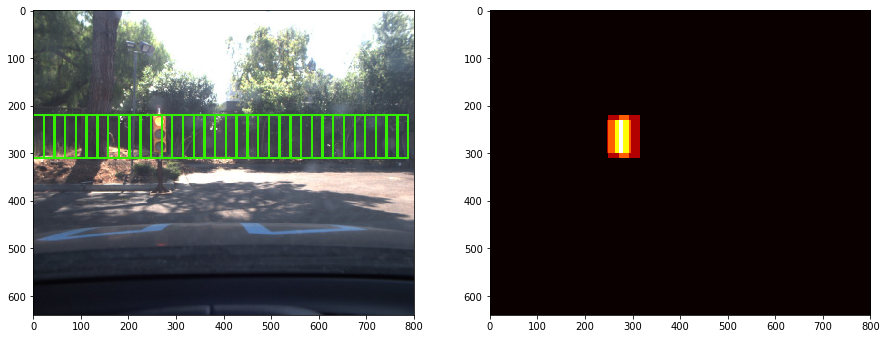

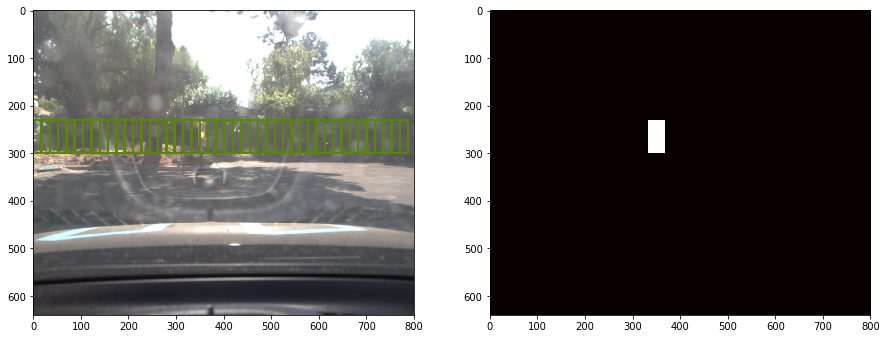

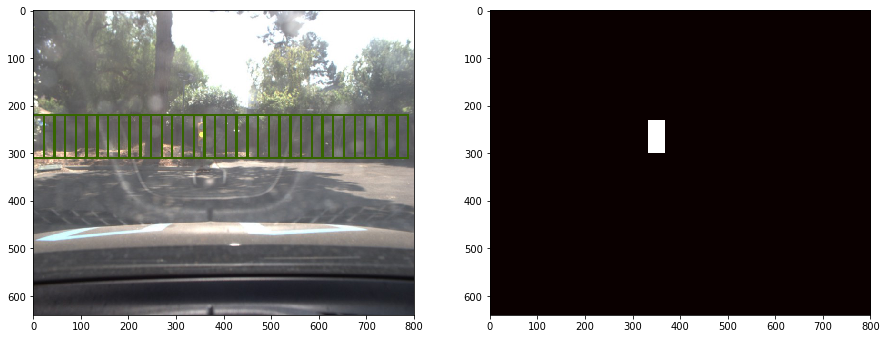

In [97]:
images = glob.glob('./test_images/carla_t*.jpg')
plt.figure(figsize=(15,10))
i=1
for imagepath in images:
    print(imagepath)
    HEAT_MAP_HISTORY.clear()
    image = mpimg.imread(imagepath)
    image = process_clip(image)
#     plt.subplot(3,3,i)
#     plt.imshow(image)
    plt.imsave('./output_images/carla_test'+str(i)+'.jpg', image)
    i+=1
plt.show()